# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

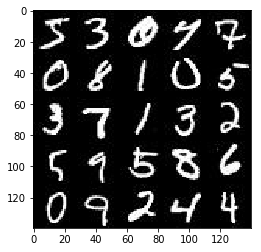

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

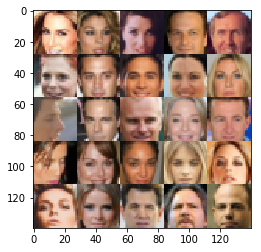

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import collections

Shape = collections.namedtuple('Shape', ('width', 'height', 'depth'))

# Shapes (just for information)
mnist_shape = Shape(28, 28, 1)
celeba_shape = Shape(28, 28, 3)

In [7]:
import functools
import operator

def flatten_size(shape):
    """Calculates flatten size by Shape"""
    return functools.reduce(operator.mul, shape)

def flatten(x, conv_shape):
    """Converts convolutional layer to dense layer"""
    return tf.reshape(x, (-1, flatten_size(conv_shape)))                    

def leaky_relu(x, alpha):
    return tf.maximum(alpha * x, x)

DISCRIMINATOR_VAR_SCOPE = 'discriminator'
                      
def discriminator(images, reuse=False, alpha=0.2, rate=0.1, kernel_size=3):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(DISCRIMINATOR_VAR_SCOPE, reuse=reuse):
        # Input layer is 28x28x1 or 28x28x3
        
        x1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        relu1 = leaky_relu(x1, alpha)
        dropout1 = tf.layers.dropout(relu1, rate, training=True)
        out1 = dropout1
        # 16x16x128 now
                
        x2 = tf.layers.conv2d(out1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2, alpha)
        dropout2 = tf.layers.dropout(relu2, rate, training=True)
        out2 = dropout2
        # 8x8x256 now
        
        x3 = tf.layers.conv2d(out2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3, alpha)
        dropout3 = tf.layers.dropout(relu3, rate, training=True)
        out3 = dropout3
        # 4x4x512 now

        out3_shape = Shape(*[int(dimension) for dimension in out3.shape[1:]])
        
        # Flatten it
        flat = flatten(out3, out3_shape)
        
        logits = tf.layers.dense(flat, 1, kernel_initializer=kernel_initializer())
        
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def start_convolutional(x, shape, kernel_initializer):
    """Starts convolutional stack
    
    shape is a Shape object
    """
    y = tf.layers.dense(x, flatten_size(shape), kernel_initializer=kernel_initializer)
    # Reshape y to start the convolutional stack
    y = tf.reshape(y, (-1, shape.width, shape.height, shape.depth))
    return y

GENERATOR_VAR_SCOPE = 'generator'

def generator(z, out_channel_dim, is_train=True, alpha=0.2, rate=0.1, kernel_size=3):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d
    
    with tf.variable_scope(GENERATOR_VAR_SCOPE, reuse=not is_train):
        
        x1 = start_convolutional(z, Shape(7, 7, 512), kernel_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leaky_relu(bn1, alpha)
        dropout1 = tf.layers.dropout(relu1, rate, training=is_train)
        out1 = dropout1
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(out1, 256, kernel_size, strides=1, padding='same',
                                        kernel_initializer=kernel_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(bn2, alpha)
        dropout2 = tf.layers.dropout(relu2, rate, training=is_train)
        out2 = dropout2
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(out2, 128, kernel_size, strides=2, padding='same',
                                        kernel_initializer=kernel_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3, alpha)
        dropout3 = tf.layers.dropout(relu3, rate, training=is_train)
        out3 = dropout3
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(out3, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=kernel_initializer())
        # 28x28x3 now (or 28x28x1)
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2,
               label_smoothness=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, reuse=False, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_out, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_real_logits, 
            labels=tf.ones_like(d_real_out) * (1 - label_smoothness)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.zeros_like(d_fake_out)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.ones_like(d_fake_out)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith(DISCRIMINATOR_VAR_SCOPE)]
    g_vars = [var for var in t_vars if var.name.startswith(GENERATOR_VAR_SCOPE)]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          alpha=0.2,
          print_every=10, show_every=50, show_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape      
    
    # Build model
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # let's go
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # images normalization [-1, 1]
                batch_images = batch_images * 2
                
                # white noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    #Print the current image
                    show_generator_output(sess, show_images, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 2.7596... Generator Loss: 7.3752
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 1.7931
Epoch 1/2... Discriminator Loss: 2.4934... Generator Loss: 6.6265


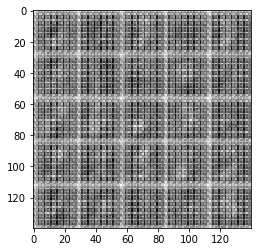

Epoch 1/2... Discriminator Loss: 0.8196... Generator Loss: 1.4940
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.5922
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.8574
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.8224
Epoch 1/2... Discriminator Loss: 1.5889... Generator Loss: 0.4737


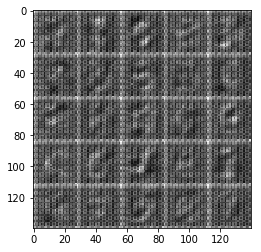

Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 2.4747
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 2.2907
Epoch 1/2... Discriminator Loss: 1.2275... Generator Loss: 2.1882
Epoch 1/2... Discriminator Loss: 1.0730... Generator Loss: 2.0596


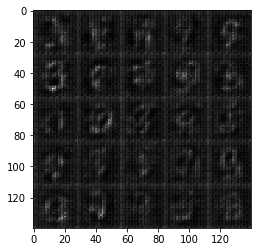

Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.5128... Generator Loss: 3.3453
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 2.4381
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.9862
Epoch 1/2... Discriminator Loss: 0.7904... Generator Loss: 1.9936


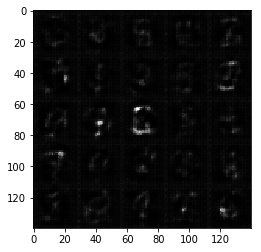

Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 2.1918
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.9642
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 0.8357
Epoch 1/2... Discriminator Loss: 0.8377... Generator Loss: 1.1262


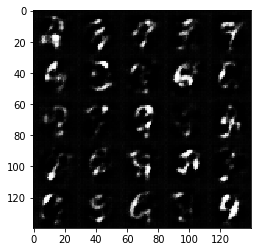

Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.4250
Epoch 1/2... Discriminator Loss: 0.8723... Generator Loss: 1.2576
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.5652
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 0.7283... Generator Loss: 1.4492


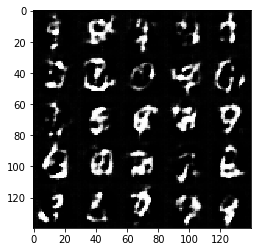

Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 3.2370
Epoch 1/2... Discriminator Loss: 1.4647... Generator Loss: 0.5231
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.7595... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 2.3808


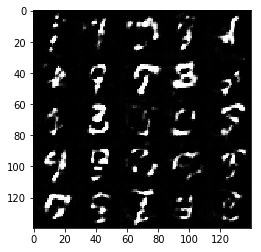

Epoch 1/2... Discriminator Loss: 0.8466... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 0.8193... Generator Loss: 1.6570
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 1.0498
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.2548... Generator Loss: 0.6728


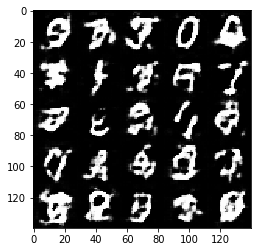

Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.7159
Epoch 1/2... Discriminator Loss: 0.7545... Generator Loss: 1.6191
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 2.2767
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 0.8785... Generator Loss: 1.6687


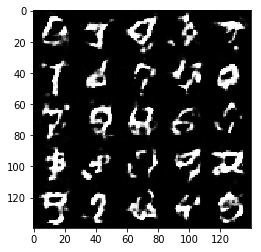

Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 2.0302
Epoch 1/2... Discriminator Loss: 1.3404... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 0.8841... Generator Loss: 1.3502
Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 1.8017
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.7776


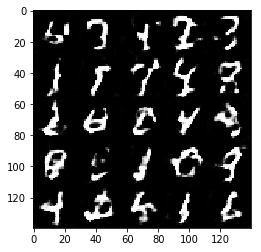

Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.8879... Generator Loss: 1.4742
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.5233
Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.3621
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.8736


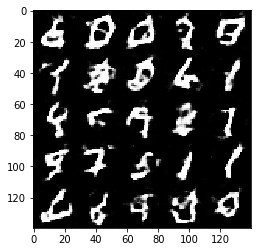

Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 1.8294
Epoch 1/2... Discriminator Loss: 1.5682... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 0.9485... Generator Loss: 1.2212
Epoch 1/2... Discriminator Loss: 0.9537... Generator Loss: 1.2277
Epoch 1/2... Discriminator Loss: 0.8859... Generator Loss: 1.8012


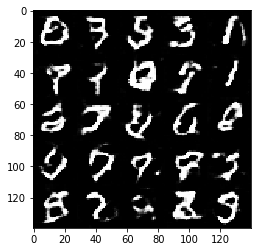

Epoch 1/2... Discriminator Loss: 0.8878... Generator Loss: 1.9521
Epoch 1/2... Discriminator Loss: 0.9011... Generator Loss: 1.2249
Epoch 1/2... Discriminator Loss: 0.9893... Generator Loss: 1.0784
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 1.0411
Epoch 1/2... Discriminator Loss: 0.9747... Generator Loss: 1.7386


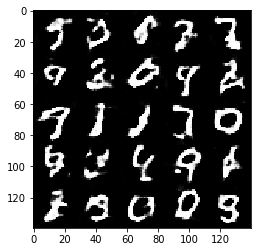

Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 2.4565
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.1027
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.2655


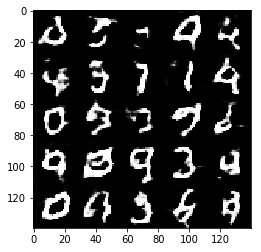

Epoch 1/2... Discriminator Loss: 0.8536... Generator Loss: 1.5437
Epoch 1/2... Discriminator Loss: 1.7406... Generator Loss: 3.1352
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.3133
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.7385


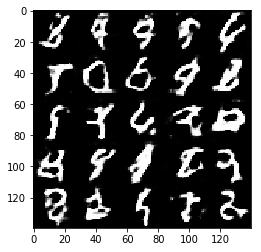

Epoch 1/2... Discriminator Loss: 0.8392... Generator Loss: 1.2237
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 1.0918
Epoch 1/2... Discriminator Loss: 0.9708... Generator Loss: 2.3858
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 1.1674


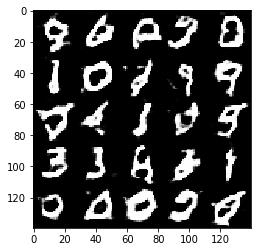

Epoch 1/2... Discriminator Loss: 0.9137... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 0.7791... Generator Loss: 1.6469
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.5396
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.8736
Epoch 1/2... Discriminator Loss: 0.8345... Generator Loss: 1.2134


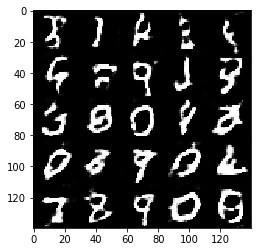

Epoch 1/2... Discriminator Loss: 2.3652... Generator Loss: 0.2527
Epoch 1/2... Discriminator Loss: 1.1023... Generator Loss: 1.9717
Epoch 1/2... Discriminator Loss: 0.7758... Generator Loss: 1.5967
Epoch 1/2... Discriminator Loss: 0.7668... Generator Loss: 1.8092
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 1.3118


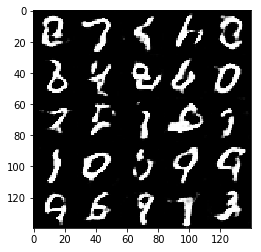

Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 0.8540... Generator Loss: 1.1929
Epoch 2/2... Discriminator Loss: 0.8078... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 0.7246... Generator Loss: 1.5323


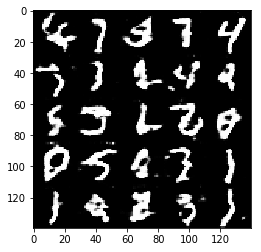

Epoch 2/2... Discriminator Loss: 0.8511... Generator Loss: 1.3554
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 1.4736
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.4228
Epoch 2/2... Discriminator Loss: 0.8136... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 1.4479


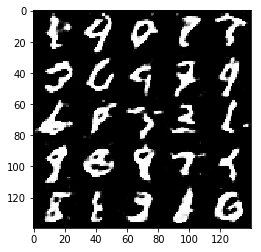

Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.8509
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 1.7557
Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 1.8940
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 1.4844... Generator Loss: 0.6534


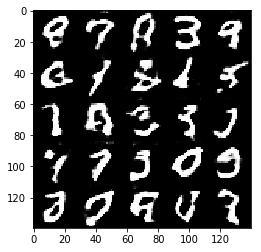

Epoch 2/2... Discriminator Loss: 0.7107... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 0.7171... Generator Loss: 1.7704
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 0.5087
Epoch 2/2... Discriminator Loss: 0.8362... Generator Loss: 1.1636


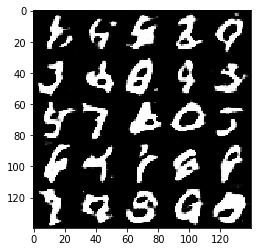

Epoch 2/2... Discriminator Loss: 0.8017... Generator Loss: 1.3538
Epoch 2/2... Discriminator Loss: 0.7356... Generator Loss: 1.7797
Epoch 2/2... Discriminator Loss: 0.7621... Generator Loss: 2.2051
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.5117
Epoch 2/2... Discriminator Loss: 0.8861... Generator Loss: 0.9832


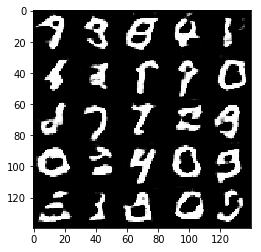

Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 1.3983
Epoch 2/2... Discriminator Loss: 2.2587... Generator Loss: 3.1898
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 1.1212
Epoch 2/2... Discriminator Loss: 0.7115... Generator Loss: 2.0542
Epoch 2/2... Discriminator Loss: 0.7049... Generator Loss: 1.6556


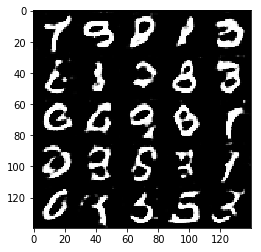

Epoch 2/2... Discriminator Loss: 0.6802... Generator Loss: 1.8872
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 3.0736
Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.8033
Epoch 2/2... Discriminator Loss: 0.8238... Generator Loss: 1.3140
Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 2.3191


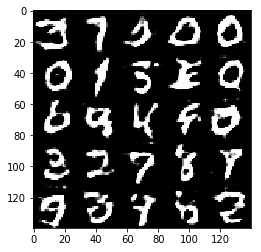

Epoch 2/2... Discriminator Loss: 1.2454... Generator Loss: 3.4243
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1993
Epoch 2/2... Discriminator Loss: 0.8197... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 1.5161
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 1.8774


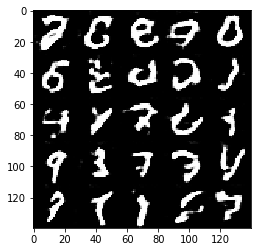

Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 2.0166
Epoch 2/2... Discriminator Loss: 0.7740... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 3.4256
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 2.0254
Epoch 2/2... Discriminator Loss: 1.0731... Generator Loss: 0.9427


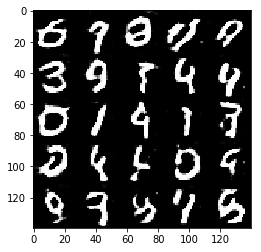

Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.7726
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.7720
Epoch 2/2... Discriminator Loss: 0.8761... Generator Loss: 1.2071
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 1.4752
Epoch 2/2... Discriminator Loss: 0.9089... Generator Loss: 2.4762


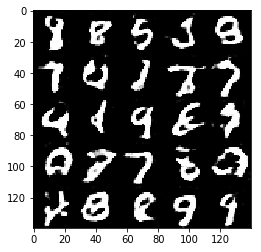

Epoch 2/2... Discriminator Loss: 1.0283... Generator Loss: 0.9237
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.5140
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 0.6159... Generator Loss: 1.9065
Epoch 2/2... Discriminator Loss: 0.8375... Generator Loss: 1.2734


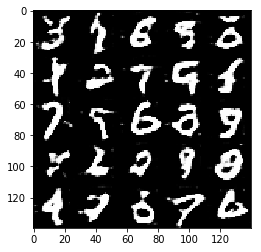

Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 1.4120
Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 0.5443... Generator Loss: 1.9691
Epoch 2/2... Discriminator Loss: 0.7863... Generator Loss: 2.3909
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 2.6687


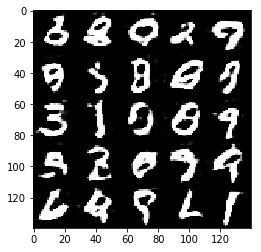

Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 1.5011
Epoch 2/2... Discriminator Loss: 0.8246... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 1.8764
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 1.9904
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 2.0708


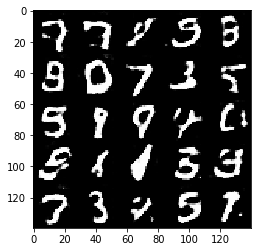

Epoch 2/2... Discriminator Loss: 0.6672... Generator Loss: 2.5501
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.1779
Epoch 2/2... Discriminator Loss: 0.6053... Generator Loss: 1.8004
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.5484
Epoch 2/2... Discriminator Loss: 0.6531... Generator Loss: 2.1906


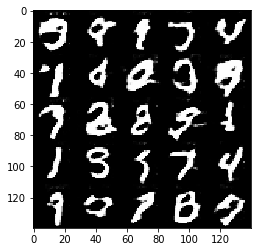

Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.5656
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 2.1162
Epoch 2/2... Discriminator Loss: 0.7447... Generator Loss: 1.5996
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.6060
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.8529


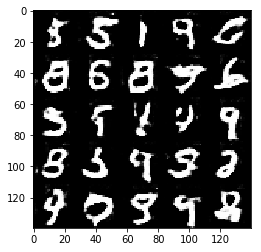

Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 1.4159
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 2.2682
Epoch 2/2... Discriminator Loss: 0.5994... Generator Loss: 2.3670
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.5556
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.8428


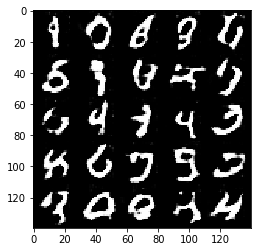

Epoch 2/2... Discriminator Loss: 0.6447... Generator Loss: 2.6228
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.1904
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.5682
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.7630
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 2.8773


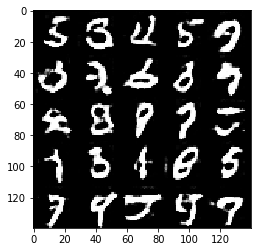

Epoch 2/2... Discriminator Loss: 0.5652... Generator Loss: 2.2596
Epoch 2/2... Discriminator Loss: 0.7070... Generator Loss: 1.5632
Epoch 2/2... Discriminator Loss: 1.9222... Generator Loss: 0.3444
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.8626
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 2.1014


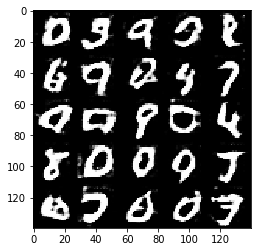

Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.2505
Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.4940
Epoch 2/2... Discriminator Loss: 0.8176... Generator Loss: 1.4403
Epoch 2/2... Discriminator Loss: 0.8207... Generator Loss: 2.5588


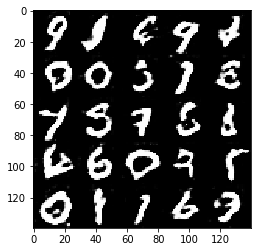

Epoch 2/2... Discriminator Loss: 0.7354... Generator Loss: 1.7687
Epoch 2/2... Discriminator Loss: 0.7517... Generator Loss: 1.5267


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.05
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha=alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.3442
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.6765
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 3.3412
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.3471


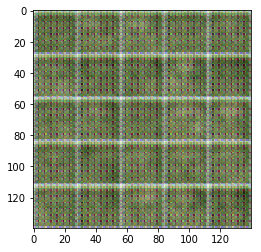

Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 2.8300
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 2.4040
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 2.3652
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.6338


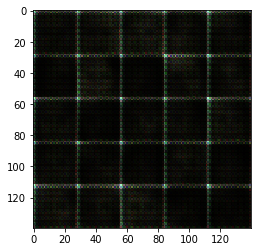

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.8536
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 2.8984
Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 1.0975
Epoch 1/1... Discriminator Loss: 0.7582... Generator Loss: 1.8161


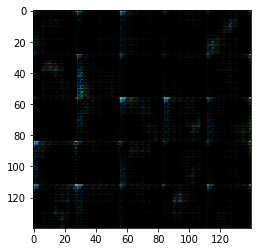

Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 3.2238
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 2.3543
Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.2221
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.5120


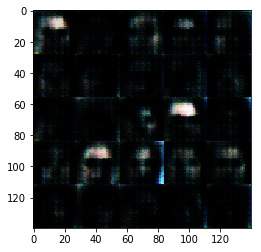

Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 1.0002
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.7024
Epoch 1/1... Discriminator Loss: 0.6939... Generator Loss: 2.8257
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.2756


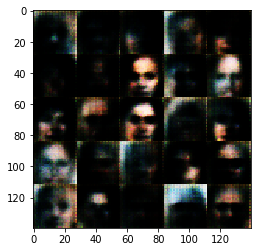

Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 2.5713
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 4.1587
Epoch 1/1... Discriminator Loss: 0.7531... Generator Loss: 2.1343
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 2.7651


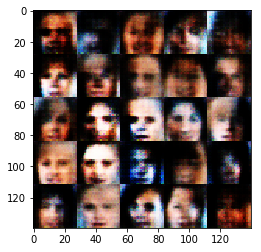

Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 3.2546
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.9170
Epoch 1/1... Discriminator Loss: 0.7313... Generator Loss: 1.8804
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 2.5912


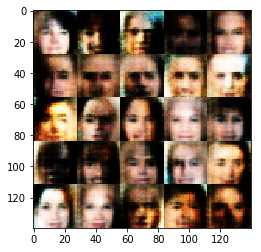

Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.0449
Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 1.4831
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 2.6438
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.6925


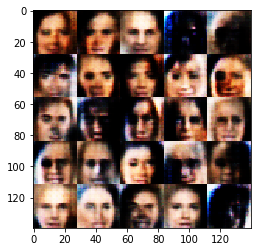

Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 2.2376
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.1674
Epoch 1/1... Discriminator Loss: 1.6032... Generator Loss: 0.5284


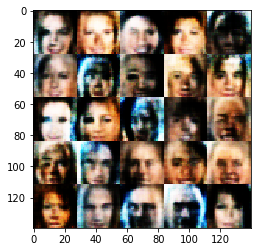

Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 2.4388
Epoch 1/1... Discriminator Loss: 0.8771... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 2.2446
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 2.3484


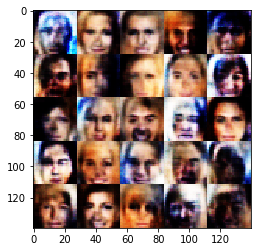

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.6520
Epoch 1/1... Discriminator Loss: 0.9591... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 1.0350... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.9277


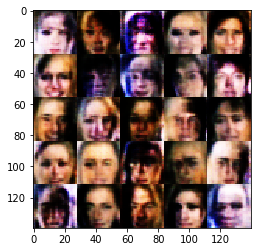

Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.9340
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 2.0744
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 2.1568
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.9075
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.5202


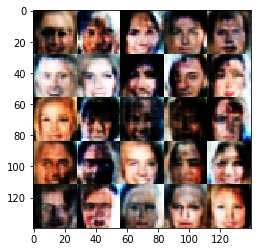

Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 2.5967
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 2.0691
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.9079


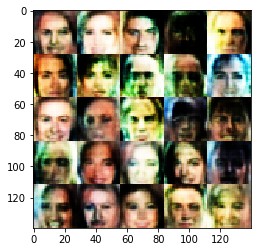

Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 2.5735
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 1.2366
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 2.2262


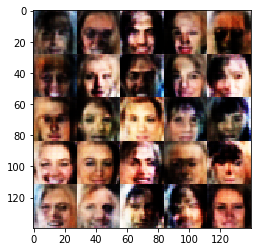

Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 2.8560
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.5209
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.5200


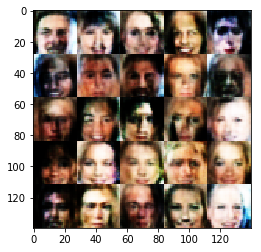

Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 2.7992
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.2819


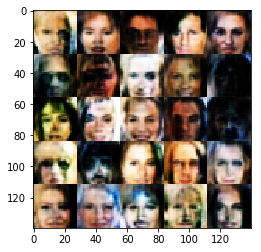

Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.2780
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 2.0069
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.4949


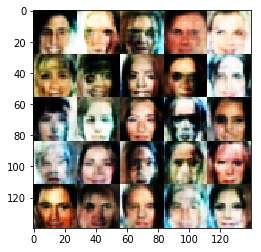

Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.5572
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.4121
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.5607


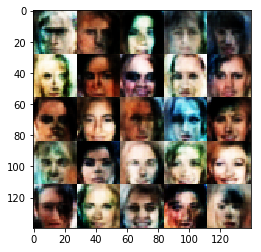

Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.8867
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.7404
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.8562


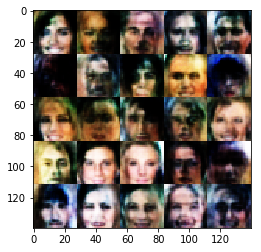

Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.2211
Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 0.9720... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 1.3978
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.3404


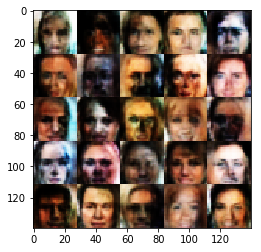

Epoch 1/1... Discriminator Loss: 0.7751... Generator Loss: 1.7746
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.4900
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 1.8226
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.4320


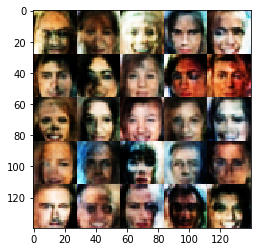

Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.9390
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.8580... Generator Loss: 0.2890
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.9852


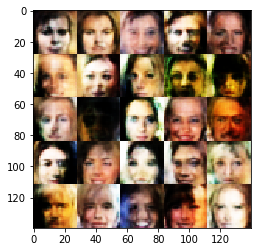

Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.2984
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 2.0981


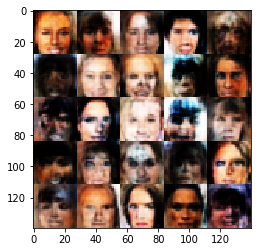

Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 2.2887
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 0.9303... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.9286
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.7734


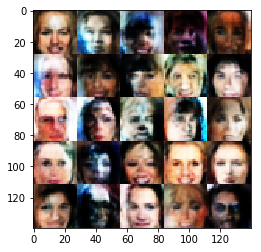

Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.9388
Epoch 1/1... Discriminator Loss: 0.9372... Generator Loss: 1.4321
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.3541


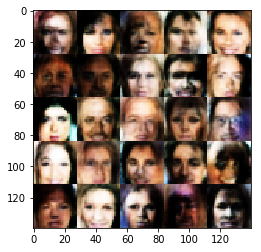

Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 2.0172
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.3441


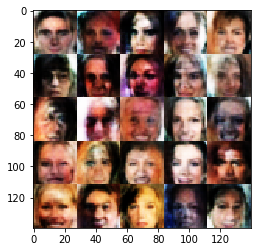

Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 2.0599
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.2251... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 1.1796


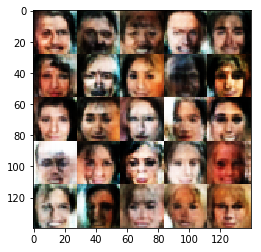

Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 1.8229
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 2.8367
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.3437
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 2.2406


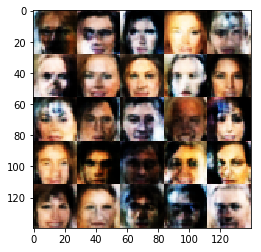

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 1.1621
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.5588


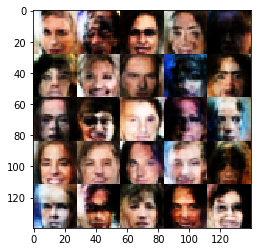

Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 2.3353
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.0404


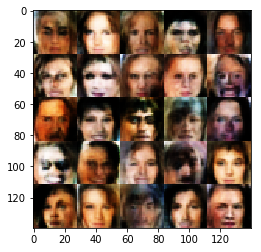

Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.0752
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.5435
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.7428


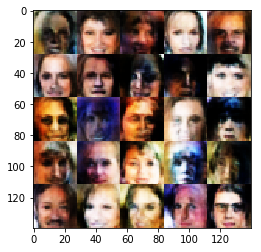

Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.5419
Epoch 1/1... Discriminator Loss: 0.7828... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8920


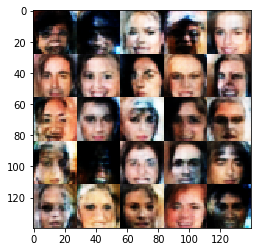

Epoch 1/1... Discriminator Loss: 1.0730... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.7571
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.3353
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 1.3886


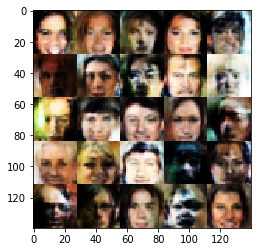

Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.2009
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.7930
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.8997
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.2680


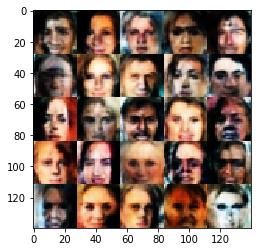

Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 2.3200
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 0.9407... Generator Loss: 1.2089


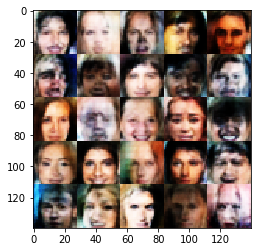

Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.3404
Epoch 1/1... Discriminator Loss: 0.7722... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.5807


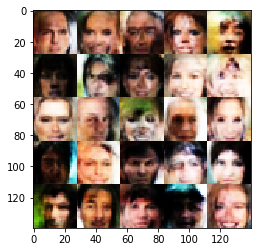

Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.0484
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 1.8279


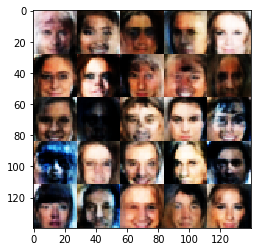

Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 2.2875


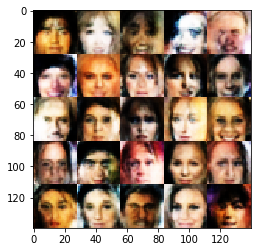

Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.3200
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 0.9808... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.3483


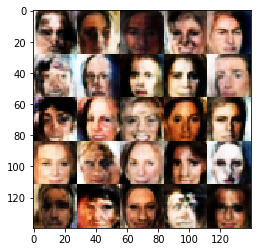

Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 2.4527
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7998


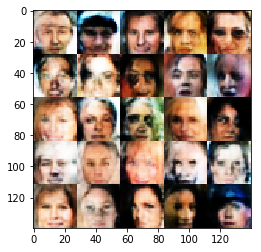

Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.9035


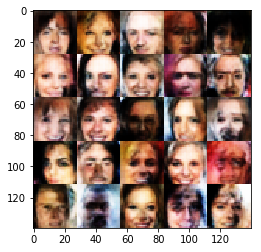

Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 1.9383
Epoch 1/1... Discriminator Loss: 1.1024... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6502


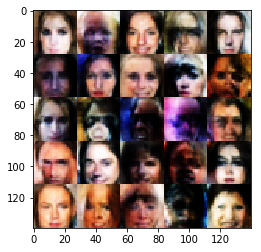

Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 2.0332
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 1.1368... Generator Loss: 1.2573


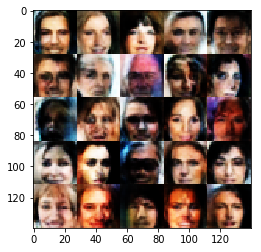

Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.5889
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 2.0073
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.8273... Generator Loss: 1.6597


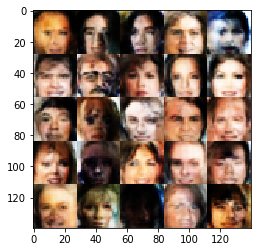

Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.1654


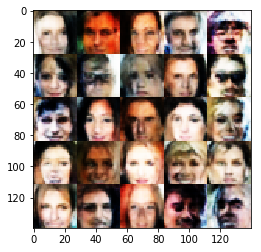

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.9917
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.9121
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.6132


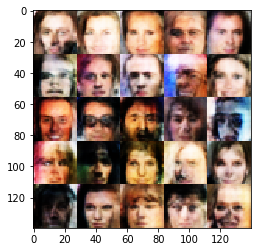

Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.2432
Epoch 1/1... Discriminator Loss: 0.9259... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 2.4932
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 0.9820... Generator Loss: 1.2630


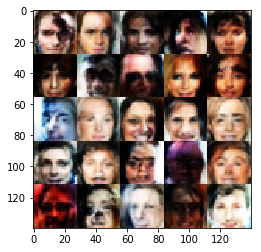

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.2759
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.1507
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.7051


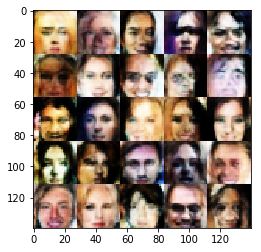

Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.1626
Epoch 1/1... Discriminator Loss: 0.8786... Generator Loss: 1.5136
Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.1648


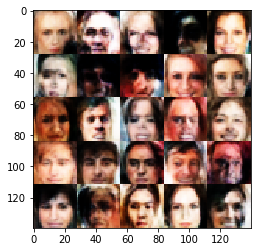

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.5671
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7517


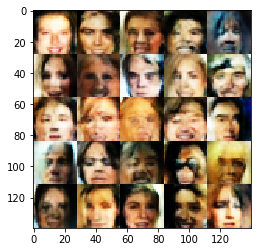

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.4269
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 2.1077
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.5987


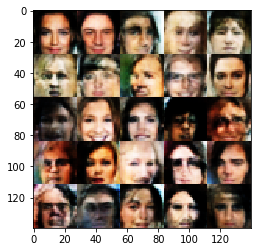

Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 2.0026
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.6370... Generator Loss: 0.4349


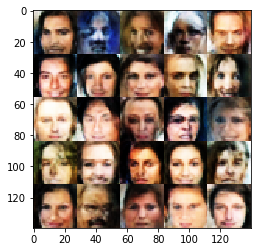

Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.9812
Epoch 1/1... Discriminator Loss: 0.9273... Generator Loss: 2.2754
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.3971


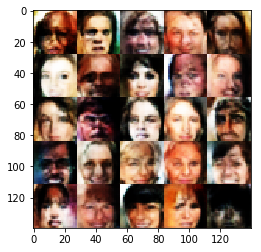

Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.4293
Epoch 1/1... Discriminator Loss: 0.9605... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0801... Generator Loss: 1.5010
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.7869


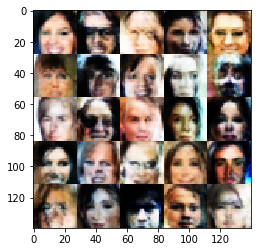

Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 1.9043
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.4207
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6692


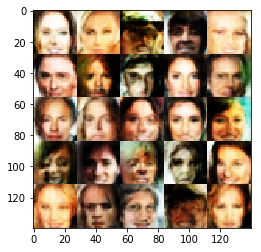

Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 2.0213
Epoch 1/1... Discriminator Loss: 2.3900... Generator Loss: 2.3912
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.1855
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 1.4290


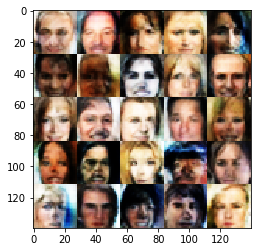

Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.5275


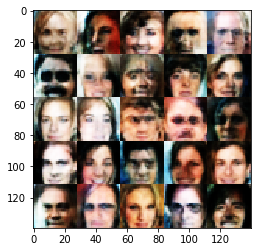

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.0264
Epoch 1/1... Discriminator Loss: 0.9555... Generator Loss: 1.0846


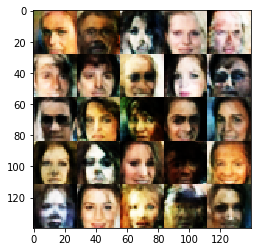

Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 2.1505
Epoch 1/1... Discriminator Loss: 1.7402... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 0.9729
Epoch 1/1... Discriminator Loss: 0.9414... Generator Loss: 1.0051


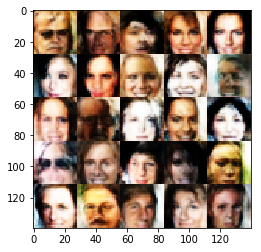

Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.1323
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.7204
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 2.1643
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5713


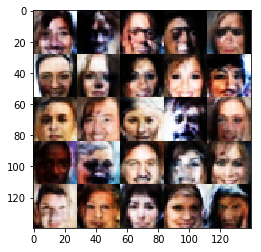

Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 2.0332
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 2.3724


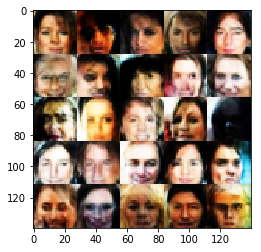

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.7491
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.2257
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.8456


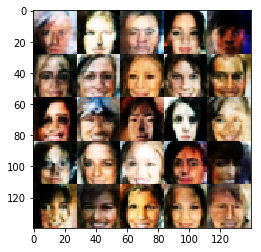

Epoch 1/1... Discriminator Loss: 0.8770... Generator Loss: 1.3075
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.6048
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 2.2184
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.6861


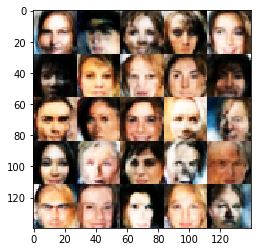

Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6405


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
alpha = 0.05
beta1 = 0.3

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha=alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.